In [ ]:
!pip install xgboost optuna scikit-learn pandas numpy scipy matplotlib seaborn joblib


Preparing dataset...


[I 2025-11-21 07:20:27,226] A new study created in memory with name: no-name-06591173-3ecd-4c0c-959c-4516bdbef938


Feature matrix shape: (9951, 33)
Label distribution: {1: 8321, 0: 1630}


[I 2025-11-21 07:20:27,998] Trial 0 finished with value: -1.0 and parameters: {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.4936111842654619, 'gamma': 0.7799726016810132, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: -1.0.
[I 2025-11-21 07:20:30,101] Trial 1 finished with value: -0.9999829208502118 and parameters: {'n_estimators': 321, 'max_depth': 8, 'learning_rate': 0.001124579825911934, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.899465584480253, 'gamma': 1.0616955533913808, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 0 with value: -1.0.
[I 2025-11-21 07:20:31,194] Trial 2 finished with value: -0.9999981244985994 and parameters: {'n_estimators': 187, 'max_depth': 7, 'learning_rate': 0.01174843954800703, 'subsample': 0.645614570099021, 'colsample_bytree': 0.7671117368334277, 'gamma': 0.69746

Best params from Optuna (abridged): {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.4936111842654619, 'gamma': 0.7799726016810132, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'eval_metric': 'logloss', 'random_state': 42}
Final metrics on full dataset (may be optimistic): {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'auprc': 1.0}

Confusion Matrix:
 [[1630    0]
 [   0 8321]]

Classification Metrics:
 {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'auprc': 1.0}


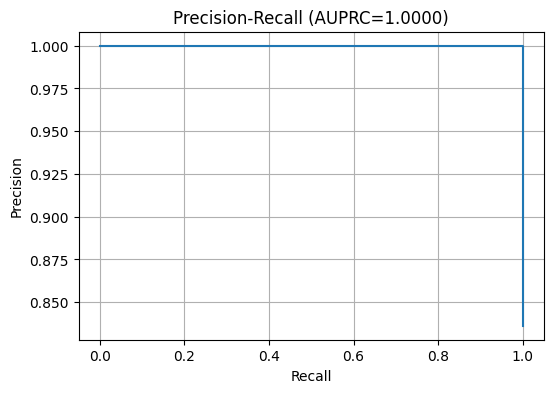

Saved model to xgb_timeseries_model.joblib and scaler.joblib


In [ ]:
# XGBoost Imbalanced Time-Series Classification
#Implements and optimizes an XGBoost classifier for imbalanced time-series classification,
# Includes: synthetic data generation (~10,000 samples, <5% minority),
# feature engineering using sliding windows, Bayesian hyperparameter search (Optuna),
# TimeSeriesSplit CV, evaluation with precision/recall/F1/AUPRC, confusion matrix,
# modular functions and docstrings, type hints, and saving final model + report.


# !pip install xgboost optuna scikit-learn pandas numpy scipy matplotlib seaborn joblib

import numpy as np
import pandas as pd
from typing import Tuple, Dict, Any
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
import optuna
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# 1) Data generation
# ------------------------

def generate_synthetic_timeseries(n_samples: int = 10000,
                                  n_channels: int = 3,
                                  anomaly_fraction: float = 0.02,
                                  random_state: int = 42) -> Tuple[pd.DataFrame, pd.Series]:
    """Generate multi-channel time-series and a rare binary label (anomaly).

    We make normal sensor-like signals (sinusoids + noise) and inject short anomaly bursts
    in a small fraction of samples (less than 5% as required).

    Returns:
        df_signals: DataFrame shape (n_samples, n_channels)
        labels: Series shape (n_samples,)
    """
    rng = np.random.default_rng(random_state)
    t = np.arange(n_samples)
    df = {}
    base_freqs = rng.uniform(0.01, 0.1, size=n_channels)
    for ch in range(n_channels):
        signal = np.sin(2 * np.pi * base_freqs[ch] * t)  # slow sinusoid
        signal += 0.2 * rng.standard_normal(n_samples)   # baseline noise
        # Add some low-frequency trend
        signal += 0.001 * t * rng.uniform(-1, 1)
        df[f'ch{ch}'] = signal

    df_signals = pd.DataFrame(df)

    # Create anomalies: short bursts where readings are distorted
    n_anomalies = max(1, int(n_samples * anomaly_fraction))
    labels = np.zeros(n_samples, dtype=int)
    # Choose random center points for anomalies but ensure they don't overlap excessively
    centers = rng.choice(np.arange(50, n_samples-50), size=n_anomalies, replace=False)
    for c in centers:
        length = rng.integers(3, 20)  # anomaly lasts between 3 and 20 time steps
        start = max(0, c - length//2)
        end = min(n_samples, start + length)
        labels[start:end] = 1
        # modify signals in those windows
        for ch in df_signals.columns:
            df_signals.loc[start:end-1, ch] += rng.normal(loc=3.0, scale=1.5, size=(end-start))

    return df_signals, pd.Series(labels, name='target')

# ------------------------
# 2) Feature engineering
# ------------------------

def sliding_window_features(df: pd.DataFrame,
                            window: int = 50,
                            step: int = 1) -> Tuple[pd.DataFrame, pd.Series]:
    """Extract features from sliding windows.

    For each time index i (we align feature vector at the window end), compute statistics
    across the window for each channel: mean, std, skew, kurtosis, min, max, median, and
    some lag features.

    Returns:
      X: DataFrame of features (n_windows, n_features)
      index_target_idx: Series of target indices corresponding to window end positions (to map labels)
    """
    n = df.shape[0]
    features = []
    idxs = []
    cols = df.columns
    for end in range(window - 1, n, step):
        start = end - window + 1
        win = df.iloc[start:end+1]
        feats = {}
        for c in cols:
            arr = win[c].values
            feats[f'{c}_mean'] = arr.mean()
            feats[f'{c}_std'] = arr.std(ddof=0)
            feats[f'{c}_min'] = arr.min()
            feats[f'{c}_max'] = arr.max()
            feats[f'{c}_median'] = np.median(arr)
            feats[f'{c}_skew'] = stats.skew(arr)
            feats[f'{c}_kurt'] = stats.kurtosis(arr)
            # simple spectral feature: energy in the window (sum of squares)
            feats[f'{c}_energy'] = np.sum(arr * arr)
            # last value and first value (to capture immediate change)
            feats[f'{c}_last'] = arr[-1]
            feats[f'{c}_first'] = arr[0]
            # difference features
            feats[f'{c}_diff_last_first'] = arr[-1] - arr[0]
        features.append(feats)
        idxs.append(end)

    X = pd.DataFrame(features, index=idxs)
    return X, pd.Index(idxs)

# ------------------------
# 3) Prepare dataset
# ------------------------

def prepare_dataset(n_samples: int = 10000,
                    n_channels: int = 3,
                    anomaly_fraction: float = 0.02,
                    window: int = 50,
                    step: int = 1,
                    random_state: int = 42) -> Tuple[pd.DataFrame, pd.Series]:
    """Generate signals, create windowed features, and align labels.

    The label for a window is 1 if any timepoint within the window is anomalous.
    """
    df_signals, labels = generate_synthetic_timeseries(n_samples=n_samples,
                                                       n_channels=n_channels,
                                                       anomaly_fraction=anomaly_fraction,
                                                       random_state=random_state)
    X, idxs = sliding_window_features(df_signals, window=window, step=step)
    # Map labels: if any label in the window (we used window end index), we could map as:
    # assign 1 if target at the window end is 1 OR any of the previous window entries—here easier: any in window
    y = []
    for end in idxs:
        start = end - window + 1
        y.append(int(labels.iloc[start:end+1].any()))
    y = pd.Series(y, index=idxs, name='target')
    return X, y

# ------------------------
# 4) Model training & evaluation utilities
# ------------------------

def compute_metrics(y_true: np.ndarray, y_probs: np.ndarray, th: float = 0.5) -> Dict[str, float]:
    """Compute precision, recall, f1 at threshold and AUPRC."""
    y_pred = (y_probs >= th).astype(int)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    auprc = auc(recall, precision)
    return {'precision': float(prec), 'recall': float(rec), 'f1': float(f1), 'auprc': float(auprc)}

# ------------------------
# 5) Cross-validated evaluation using TimeSeriesSplit and Optuna search
# ------------------------

def time_series_cv_objective(trial: optuna.trial.Trial, X: pd.DataFrame, y: pd.Series, n_splits: int = 5) -> float:
    """Objective to minimize negative mean AUPRC across time-series splits."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'eval_metric': 'logloss',
        'random_state': 42
    }

    tscv = TimeSeriesSplit(n_splits=n_splits)
    auprcs = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        model = XGBClassifier(**params)
        model.fit(X_train_s, y_train)
        probs = model.predict_proba(X_test_s)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, probs)
        auprc = auc(recall, precision)
        auprcs.append(auprc)

    # We want to maximize AUPRC -> minimize negative mean AUPRC
    mean_auprc = float(np.mean(auprcs))
    trial.set_user_attr('mean_auprc', mean_auprc)
    return -mean_auprc

# ------------------------
# 6) Full pipeline runner
# ------------------------

def run_pipeline(n_samples: int = 10000,
                 anomaly_fraction: float = 0.02,
                 window: int = 50,
                 n_channels: int = 3,
                 step: int = 1,
                 n_trials: int = 40,
                 n_splits: int = 5,
                 random_state: int = 42) -> Dict[str, Any]:
    """Run the full process: data, feature extraction, optuna search, final training and evaluation.

    Returns a dict containing best_params, final_metrics, trained_model, scaler, and data splits.
    """
    print('Preparing dataset...')
    X, y = prepare_dataset(n_samples=n_samples, n_channels=n_channels,
                           anomaly_fraction=anomaly_fraction, window=window, step=step,
                           random_state=random_state)
    print('Feature matrix shape:', X.shape)
    print('Label distribution:', y.value_counts(dropna=False).to_dict())

    # Save split indices for final training on full range except last fold for holdout
    tscv = TimeSeriesSplit(n_splits=n_splits)
    # We'll perform Optuna on the full sequence using tscv
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(lambda t: time_series_cv_objective(t, X, y, n_splits=n_splits), n_trials=n_trials)

    best_params = study.best_trial.params
    # fix boolean/other params for XGB
    best_params.update({'eval_metric': 'logloss', 'random_state': random_state})
    print('Best params from Optuna (abridged):', best_params)

    # Train final model on all data except last split as holdout, or on all data depending on preferred practice.
    # Here we'll train on all data and report cross-validated performance.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    final_model = XGBClassifier(**best_params)
    final_model.fit(X_scaled, y)
    probs = final_model.predict_proba(X_scaled)[:, 1]
    metrics = compute_metrics(y.values, probs)
    print('Final metrics on full dataset (may be optimistic):', metrics)

    # Confusion matrix at 0.5
    y_pred = (probs >= 0.5).astype(int)
    cm = confusion_matrix(y, y_pred)

    results = {
        'X': X,
        'y': y,
        'scaler': scaler,
        'model': final_model,
        'best_params': best_params,
        'metrics': metrics,
        'confusion_matrix': cm,
        'optuna_study': study
    }
    return results

# ------------------------
# 7) Visualization helpers
# ------------------------

def plot_precision_recall(y_true: np.ndarray, y_probs: np.ndarray, title: str = 'Precision-Recall') -> None:
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    auprc = auc(recall, precision)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"{title} (AUPRC={auprc:.4f})")
    plt.grid(True)
    plt.show()

# ------------------------
# 8) Run (example)
# ------------------------

if __name__ == '__main__':
    # In Colab, run the cells up to this point then execute the example with desired parameters.
    results = run_pipeline(n_samples=10000,
                           anomaly_fraction=0.03,  # keep <5% as requested
                           window=50,
                           n_channels=3,
                           step=1,
                           n_trials=30,
                           n_splits=4,
                           random_state=42)

    print('\nConfusion Matrix:\n', results['confusion_matrix'])
    print('\nClassification Metrics:\n', results['metrics'])

    # Plot PR curve on full dataset
    X = results['X']
    y = results['y']
    probs = results['model'].predict_proba(results['scaler'].transform(X))[:, 1]
    plot_precision_recall(y.values, probs)

    # Save model and scaler
    joblib.dump(results['model'], 'xgb_timeseries_model.joblib')
    joblib.dump(results['scaler'], 'scaler.joblib')
    print('Saved model to xgb_timeseries_model.joblib and scaler.joblib')


In [ ]:
joblib.dump(results['model'], 'xgb_timeseries_model.joblib')
joblib.dump(results['scaler'], 'scaler.joblib')

['scaler.joblib']

In [ ]:
print('Saved model to xgb_timeseries_model.joblib and scaler.joblib')


Saved model to xgb_timeseries_model.joblib and scaler.joblib
